## Phase 4 Project Submission
* Student name: Simran Kaur
* Student pace: Part Time
* Scheduled project review date/time: Wednesday, January 10th.
* Instructor name: Morgan Jones
* Blog post URL: TBD

# SXSW - Twitter Sentiment Analysis

## Overview
South by Southwest ("SXSW") is a world premier event that showcases new music, films and interactive media. It takes place in Austin, Texas every year. 

Festival directors have reached out to see what improvements can be made from this year's festival so that it can be improved for next year. 

This analysis will use Natural Language Processing ("NLP") to develop models that can determine Twitter tweet sentiments. Tweets from this year's festival will be used to observe sentiment.

## Importing Libraries

In [265]:
# Data manipulation 
import pandas as pd 
import numpy as np 

# Data visualization
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 

# Libraries for text preprocessing
import re # RegEx for removing non-letter characters
import nltk
import string
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from wordcloud import WordCloud

# Libraries for modeling
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Algorithms for using supervised learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

#filter warnings
import warnings
warnings.filterwarnings('ignore')

## Obtaining & Understanding the Data

Data was taken from [data.world](https://data.world/crowdflower/brands-and-product-emotions). It contains over 9,000 different tweets from when the SXSW festival took place, the device it was tweeted on and if there is a positive, negative or neutral emotion to the tweet. 

This data will be helpful in the analysis as it has emotions tagged to tweets. 

In [266]:
pd.set_option("display.max_colwidth", 200) 

In [267]:
# Read data from csv file & create dataframe. Preview first 10 rows.
df = pd.read_csv("tweet_data.csv",encoding='latin-1')
df.head(10)

tweet_text  \
0               .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1   @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                               @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                            @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4           @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
5  @teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd   
6                                                                                                                                           NaN   
7    #SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan   
8             Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB   
9                                                      Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   
5                             NaN   
6                             NaN   
7                         Android   
8              iPad or iPhone App   
9                           Apple   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  
5                 No emotion toward brand or product  
6                 No emotion toward brand or product  
7                                   Positive emotion  
8                                   Positive emotion  
9                                   Positive emotion

In [268]:
# Assess dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [269]:
# Get shape to determine number of rows & columns
df.shape

(9093, 3)

In [270]:
# Get different values in the "emotion_in_tweet_is_directed_at" column
df.emotion_in_tweet_is_directed_at.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [271]:
# Get different values in the "is_there_an_emotion_directed_at_a_brand_or_product" column
df.is_there_an_emotion_directed_at_a_brand_or_product.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

## Data Prep
This section prepares the data for EDA and modeling. Columns will be renamed and the dataset will be checked for duplicated rows & missing values.

In [272]:
# Rename columns
df.rename(columns={"tweet_text":"tweet"},inplace = True)
df.rename(columns={"emotion_in_tweet_is_directed_at":"device"},inplace = True)
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product":"emotion"},inplace = True)

In [273]:
# Check for duplicated rows
df.duplicated().sum()

22

In [274]:
# Drop 22 duplicated rows
df.drop_duplicates(inplace=True)

In [275]:
# Confirm there are no more duplicates
df.duplicated().sum()

0

In [276]:
# Check for missing values
percent_missing = round(df.isnull().sum() * 100 / len(df),3)
missing_value_df = pd.DataFrame({'Missing_Percentage': percent_missing})
missing_value_df.sort_values(by="Missing_Percentage",ascending=False).head(20)

Missing_Percentage
device               63.819
tweet                 0.011
emotion               0.000

In [277]:
# Drop device column as 64% is missing
df.drop(['device'],axis=1,inplace=True)

In [278]:
# Drop the tweet rows that are missing. Recheck dataframe
df.dropna(subset=['tweet'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9070 non-null   object
 1   emotion  9070 non-null   object
dtypes: object(2)
memory usage: 212.6+ KB


## Explanatory Data Analysis ("EDA")

### Feature Engineering the "Emotion" Feature

In [279]:
# Check the value counts in the "emotion" column
df['emotion'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

In [280]:
# Treat "I can't tell" as null values and drop them
to_drop = ["I can't tell"]
df = df[df.emotion.isin(to_drop) == False]
df

tweet  \
0                       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1           @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                       @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4                   @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   
...                                                                                                                                                 ...   
9088                                                                                                                      Ipad everywhere. #SXSW {link}   
9089                      Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles   
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   
9091       Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.   
9092                                           ¬å√è¬°¬é√è√†¬ä√º_¬ã¬Å√ä¬ã¬Å√é¬ã¬Å√í¬ã¬Å¬£¬ã¬Å√Å¬ã√¢√¢¬ã¬Å_¬ã¬Å¬£¬ã¬Å¬è¬ã√¢_¬ã√õ√¢RT @mention Google Tests ¬â√õ√èCheck-in Offers¬â√õ¬ù At #SXSW {link}   

                                 emotion  
0                       Negative emotion  
1                       Positive emotion  
2                       Positive emotion  
3                       Negative emotion  
4                       Positive emotion  
...                                  ...  
9088                    Positive emotion  
9089  No emotion toward brand or product  
9090  No emotion toward brand or product  
9091  No emotion toward brand or product  
9092  No emotion toward brand or product  

[8914 rows x 2 columns]

In [281]:
# Combine "No emotion towards brand or product"
df["emotion"] = np.where(df["emotion"].str.contains("No emotion toward brand or product"),
                         'Neutral emotion',df["emotion"])

In [282]:
# Recheck "emotion" value counts
df['emotion'].value_counts()

Neutral emotion     5375
Positive emotion    2970
Negative emotion     569
Name: emotion, dtype: int64

### SXSW in Tweets Analysis 

In [283]:
# Filter out the tweets that contain "sxsw"
df2 = df[df['tweet'].str.contains('sxsw')]
print(df2)

                                                                                                                                                  tweet  \
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
8                     Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB   
9                                                              Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear   
10                               Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail   
14                                                                                    Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l   
...                                                                   

4,596 tweets are related to SXSW. 

In [284]:
emotion = df2['emotion'].value_counts()
transuction = emotion.index
quantity = emotion.values

# draw pie circule with plotly
figure = px.pie(df, values = quantity, names = transuction,hole = .4, title = 'Distribution of the "emotion" Feature')
figure.show()

### Feature Engineering the "Tweet" Feature

In [285]:
# Define cleanup rules
def cleanTweets(tweets):
    twt = tweets.lower() #convert all letters to lower case
    twt = re.sub("@[A-Za-z0-9_]+","", twt) #remove mentions
    twt = re.sub(r"http\S+", "", twt) #remove url's https tags
    twt = re.sub(r"www.\S+", "", twt) #remove url's www tags
    twt = re.sub("[^a-z0-9]"," ", twt) #remove non-alphanumeric characters
    twt = re.sub('[\s]+', ' ', twt) #Remove additional white spaces
    twt = re.sub(r"sxsw", "", twt) #Remove sxsw from tweets
    return twt

In [286]:
# Apply cleanup rules to "tweet" column
cleantext=[]
for item in tqdm(df2['tweet']):
    twt = cleanTweets(item)
    cleantext += [twt]
df2['clean_tweet']=cleantext
df2

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4596/4596 [00:00<00:00, 31088.51it/s]


tweet  \
3                                                                    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
8                     Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB   
9                                                              Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear   
10                               Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail   
14                                                                                    Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l   
...                                                                                                                                                 ...   
9080              Diller says Google TV &quot;might be run over by the PlayStation and the Xbox, which are essentially ready today.&quot; #sxsw #diller   
9081                              Google says reports about launch of Circles social network at #sxsw are incorrect {link} No launch today at any rate.   
9082                                                    #Apple guys screaming and running by line to open the shop #austin #sxsw #ipad2 #crazyco {link}   
9089                      Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles   
9090  Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev   

               emotion  \
3     Negative emotion   
8     Positive emotion   
9     Positive emotion   
10    Positive emotion   
14    Positive emotion   
...                ...   
9080  Negative emotion   
9081   Neutral emotion   
9082   Neutral emotion   
9089   Neutral emotion   
9090   Neutral emotion   

                                                                                                                                clean_tweet  
3                                                                    i hope this year s festival isn t as crashy as this year s iphone app   
8                                                            beautifully smart and simple idea rt wrote about our hollergram ipad app for    
9                                                       counting down the days to  plus strong canadian dollar means stock up on apple gear  
10                                             excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                                                                    great  ipad app from   
...                                                                                                                                     ...  
9080            diller says google tv quot might be run over by the playstation and the xbox which are essentially ready today quot  diller  
9081                         google says reports about launch of circles social network at  are incorrect link no launch today at any rate   
9082                                                  apple guys screaming and running by line to open the shop austin  ipad2 crazyco link   
9089                                 wave buzz rt we interrupt your regularly scheduled  geek programming with big news link google circles  
9090  google s zeiger a physician never reported potential ae yet fda relies on physicians quot we re operating w out data quot  health2dev  

[4596 rows x 3 columns]

In [287]:
# Drop uncleaned "tweet" column
df2 = df2.drop(['tweet'],axis=1)
df2.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
9   Positive emotion   
10  Positive emotion   
14  Positive emotion   

                                                                                     clean_tweet  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
9            counting down the days to  plus strong canadian dollar means stock up on apple gear  
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from

### WordClouds

In [288]:
# Define function to create a WordCloud
def create_corpus_df(tweet, emotion):
    corpus=[]
    
    for x in df2[df2['emotion']==emotion]['clean_tweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

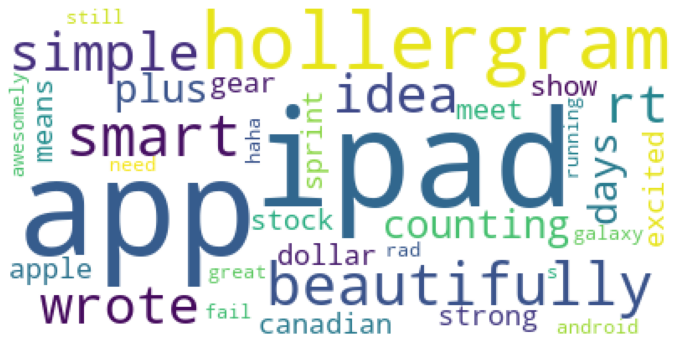

In [289]:
# WordCloud for "Positive emotion" tweets 
corpus_new1=create_corpus_df(df2,'Positive emotion')
len(corpus_new1)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:60]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

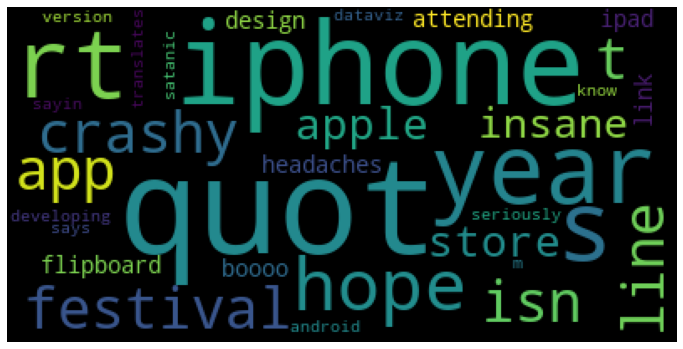

In [290]:
# WordCloud for "Negative emotion" tweets 
corpus_new2=create_corpus_df(df2,'Negative emotion')
len(corpus_new2)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new2[:60]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

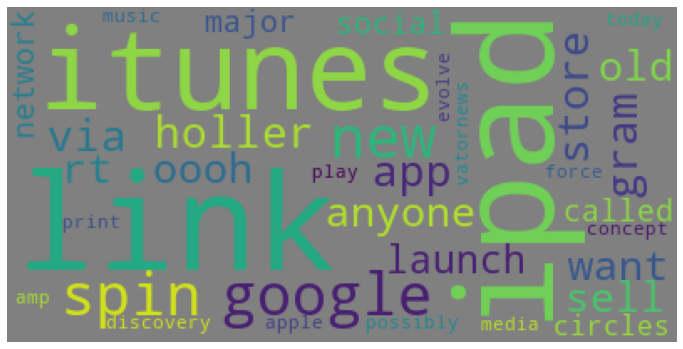

In [291]:
# WordCloud for "Neutral emotion" tweets 
corpus_new3=create_corpus_df(df2,'Neutral emotion')
len(corpus_new3)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='gray',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new3[:60]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

* SXSW is mentioned in all three WordClouds. This is understandable as the data is from when the South by SouthWest film festival took place. 
* Iphone is mentioned in both the positive and negative WordClouds.

### Tweet Length Analysis

In [292]:
# Create a new feature "tweet_length" to show the lengths of the tweets
df2['tweet_length'] = df2['clean_tweet'].apply(len) 
df2.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
9   Positive emotion   
10  Positive emotion   
14  Positive emotion   

                                                                                     clean_tweet  \
3                         i hope this year s festival isn t as crashy as this year s iphone app    
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for     
9            counting down the days to  plus strong canadian dollar means stock up on apple gear   
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail   
14                                                                         great  ipad app from    

    tweet_length  
3             71  
8             78  
9             83  
10            92  
14            21

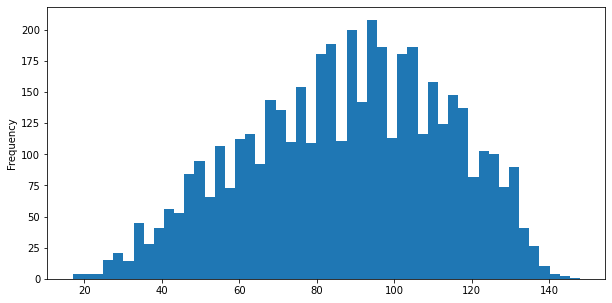

In [293]:
# Plot distribution for tweet_length
plt.figure(figsize=(10,5))
df2['tweet_length'].plot(bins=50, kind='hist'); 

* The distribution is normal and seems to be slightly skewed to the right side. 
* The left tail is heavier, which makes sense as tweets are meant to be sweet and simple. The left tail is an indicator of tweets with fewer characters.

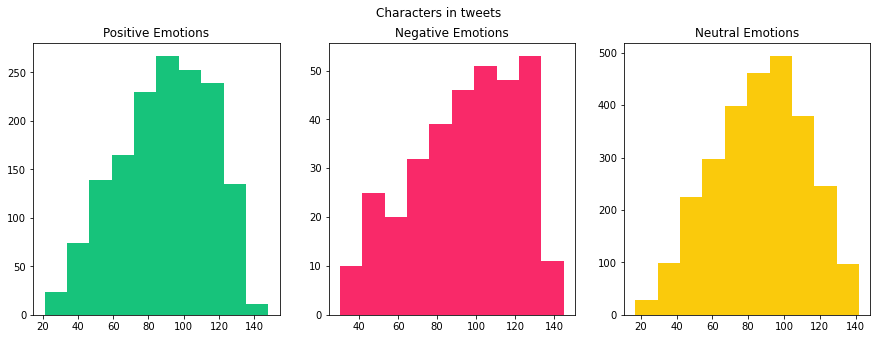

In [294]:
# Plot histograms for the characters in each emotion
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=df2[df2['emotion']=="Positive emotion"]['tweet_length']
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Emotions')

tweet_len=df2[df2['emotion']=="Negative emotion"]['tweet_length']
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Emotions')

tweet_len=df2[df2['emotion']=="Neutral emotion"]['tweet_length']
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Emotions')

fig.suptitle('Characters in tweets')
plt.show()

* Neutral emotions has the highest character count and understandable so. That emotion has the most number of tweets. 
* Between positive and negative tweets, character count for positive tweets are higher. 
* All histograms look normally distrubuted, with a slight skew to the right side.

In [295]:
# Drop tweet_length as it is no longer needed. Recheck dataframe. 
df2.drop(['tweet_length'],axis=1,inplace=True)
df2.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
9   Positive emotion   
10  Positive emotion   
14  Positive emotion   

                                                                                     clean_tweet  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
9            counting down the days to  plus strong canadian dollar means stock up on apple gear  
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from

### N-Gram Analysis
* N-gram modeling is a techniques used to convert text from an unstructured format to a structured format.
* N-grams of texts are extensively used in text mining and NLP tasks. They are basically a set of co-occurring words within a given window and when computing the n-grams, you typically move one word forward.
* In the fields of computational linguistics and probability, an n-gram (sometimes also called Q-gram) is a contiguous sequence of n items from a given sample of text or speech.
* A bigram (n=2) analysis over the tweets.

In [296]:
# Define function to get n-grams
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

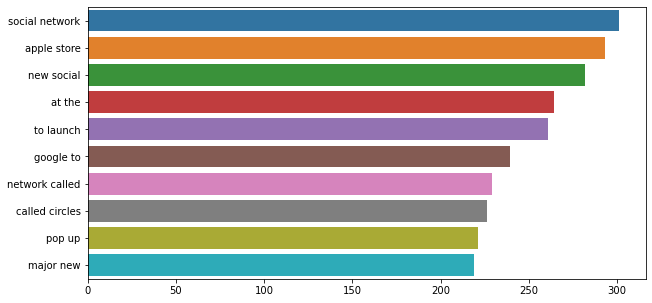

In [297]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df2['clean_tweet'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x);

### Removing Punctions
* Punctuation marks such as commas, apostrophes, quotations and question marks will be removed from the texts.

In [298]:
# Define function to remove punctuation
def remove_punctuation(description):
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

In [299]:
# Apply function
df2['clean_tweet'] = df2['clean_tweet'].apply(remove_punctuation)
df2.head()

emotion  \
3   Negative emotion   
8   Positive emotion   
9   Positive emotion   
10  Positive emotion   
14  Positive emotion   

                                                                                     clean_tweet  
3                         i hope this year s festival isn t as crashy as this year s iphone app   
8                 beautifully smart and simple idea rt wrote about our hollergram ipad app for    
9            counting down the days to  plus strong canadian dollar means stock up on apple gear  
10  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail  
14                                                                         great  ipad app from

### Removing Emojis

In [300]:
# Define function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake üòîüòî")

'Omg another Earthquake '

In [301]:
# Apply function
df2['clean_tweet_text']=df2['clean_tweet'].apply(lambda x: remove_emoji(x))

### Count Vectorizer
* In order to use textual data for predictive modeling, the text must be parsed to remove certain words ‚Äì this process is called tokenization. These words need to then be encoded as integers, or floating-point values, for use as inputs in machine learning algorithms. This process is called feature extraction (or vectorization).
* Countvectorizer is a method to convert text to numerical data.
* Scikit-learn‚Äôs CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

In [302]:
vectorizer = CountVectorizer()
vectorizer.fit(df2['clean_tweet'])
vector = vectorizer.transform(df2['clean_tweet'])
print(vector.shape)

(4596, 6910)


### TF-IDF
* TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.
* The TF-IDF algorithm is used to weigh a keyword in any content and assign importance to that keyword based on the number of times it appears in the document.
* TF is a measure of how often a phrase appears in a document, and IDF is about how important that phrase is. The multiplication of these two scores makes up a TF-IDF score.

In [303]:
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()

In [304]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Train-Test Split and Applying SMOTE to "emotion" Feature
* SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.
* The technique aims to balance class distribution by randomly increasing minority class examples by replicating them.

Neutral emotion     2725
Positive emotion    1536
Negative emotion     335
Name: emotion, dtype: int64


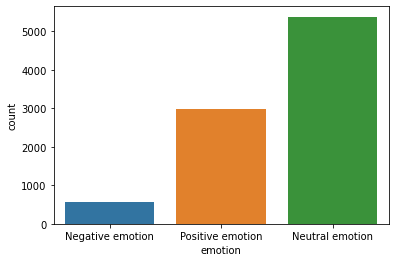

In [305]:
# Check counts for the "emotion" feature
print(df2.emotion.value_counts())
sns.countplot(data=df, x='emotion');

In [306]:
# Test-train split
X = X_tfidf
y = df2['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 123)

In [307]:
# Apply SMOTE
sm = SMOTE(k_neighbors=5, random_state=123)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('Before OverSampling, the shape of y_train: {}'.format(y_train.shape)) 
print('After OverSampling, the shape of X_train_over: {}'.format(X_train_over.shape))
print('After OverSampling, the shape of y_train_over: {}'.format(y_train_over.shape))

Before OverSampling, the shape of X_train: (3447, 6910)
Before OverSampling, the shape of y_train: (3447,)
After OverSampling, the shape of X_train_over: (6174, 6910)
After OverSampling, the shape of y_train_over: (6174,)


Negative emotion    2058
Neutral emotion     2058
Positive emotion    2058
Name: emotion, dtype: int64


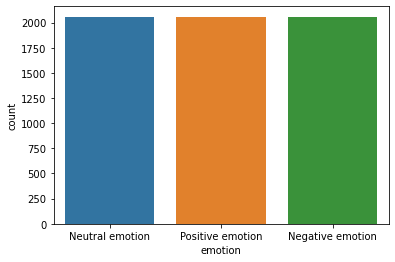

In [308]:
# Recheck counts for "emotion"
y_train_over_df = y_train_over.to_frame()
print(y_train_over_df.emotion.value_counts())
sns.countplot(data=y_train_over_df, x='emotion');

## Modeling

### Model 1 - Logistic Regression Classifier
* Logistic regression is a classification algorithm, used when the value of the target variable is categorical in nature.
* It is most commonly used when the data in question has binary output, so when it belongs to one class or another, or is either a 0 or 1.
* This method will be used to create a baseline model.

In [309]:
lr= LogisticRegression() # Object creation
lr.fit(X_train_over,y_train_over) # Fitting the data into the algorithm
y_pred_lr = lr.predict(X_test) # Getting the predictions
ytest = np.array(y_test)
log_df = pd.DataFrame(y_pred_lr,columns=["Pred_LogisticRegression"])

In [310]:
print(classification_report(ytest,y_pred_lr))

                  precision    recall  f1-score   support

Negative emotion       0.31      0.43      0.36        79
 Neutral emotion       0.73      0.72      0.72       667
Positive emotion       0.60      0.57      0.59       403

        accuracy                           0.65      1149
       macro avg       0.55      0.57      0.56      1149
    weighted avg       0.65      0.65      0.65      1149



**************** LOGISTIC REGRESSION CLASSIFIER (BASELINE) MODEL RESULTS **************** 
Accuracy score for testing set:  0.646
F1 score for testing set:  0.649
Recall score for testing set:  0.646
Precision score for testing set:  0.654


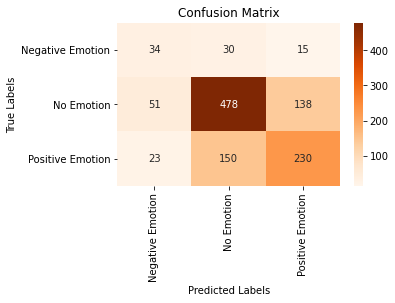

In [311]:
print("**************** LOGISTIC REGRESSION CLASSIFIER (BASELINE) MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_lr),3))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_lr,average='weighted'),3))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_lr,average='weighted'),3))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_lr,average='weighted'),3))
cm_lr = confusion_matrix(y_test, y_pred_lr)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_lr, annot=True, cmap='Oranges', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion']) ; 
ax.yaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show();

### Model 2 - Support Vector Classifier Model
* Support Vector Machine ("SVM") is best used to solve classification problems. 
* The objective of the SVM algorithm is to find a hyperplane in an N-dimensional space that distinctly classifies the data points. The hyperplane dimensions depends on the number of features. 

In [312]:
svc = LinearSVC()
svc.fit(X_train_over, y_train_over)
y_pred_svc = svc.predict(X_test)
ytest = np.array(y_test)
svc_df = pd.DataFrame(y_pred_svc,columns=["Pred_SVC"])

In [313]:
print(classification_report(ytest,y_pred_svc))

                  precision    recall  f1-score   support

Negative emotion       0.33      0.35      0.34        79
 Neutral emotion       0.72      0.73      0.72       667
Positive emotion       0.59      0.56      0.57       403

        accuracy                           0.64      1149
       macro avg       0.54      0.55      0.55      1149
    weighted avg       0.64      0.64      0.64      1149



**************** SUPPORT VECTOR CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.645
F1 score for testing set:  0.645
Recall score for testing set:  0.645
Precision score for testing set:  0.645


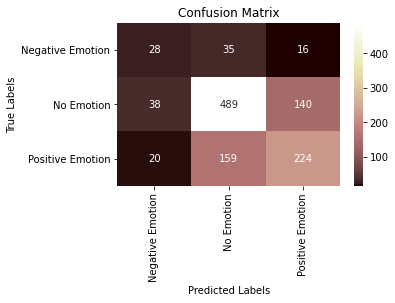

In [314]:
print("**************** SUPPORT VECTOR CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_svc),3))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_svc,average='weighted'),3))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_svc,average='weighted'),3))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_svc,average='weighted'),3))
cm_svc = confusion_matrix(y_test, y_pred_svc)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_svc, annot=True, cmap='pink', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion']) ; 
ax.yaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show();

### Model 3 - Complement Naive Bayes Classifier Model
* The Complement Naive Bayes ("CNB") model is best suited to work with imbalanced datasets.
* Contrary to the normal Naive Bayes model, this version calculates the probability of an item belonging to all of the classes. 

In [315]:
nbc = ComplementNB()
nbc.fit(X_train_over, y_train_over)
ytest = np.array(y_test)
pred_y_nb = nbc.predict(X_test)
naive_df = pd.DataFrame(pred_y_nb,columns=["Pred_ComplementNB"])

In [316]:
print(classification_report(y_test,pred_y_nb))

                  precision    recall  f1-score   support

Negative emotion       0.24      0.61      0.35        79
 Neutral emotion       0.75      0.54      0.63       667
Positive emotion       0.53      0.61      0.57       403

        accuracy                           0.57      1149
       macro avg       0.51      0.59      0.51      1149
    weighted avg       0.64      0.57      0.59      1149



**************** COMPLEMENT NAIVE BAYES CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.573
F1 score for testing set:  0.59
Recall score for testing set:  0.573
Precision score for testing set:  0.639


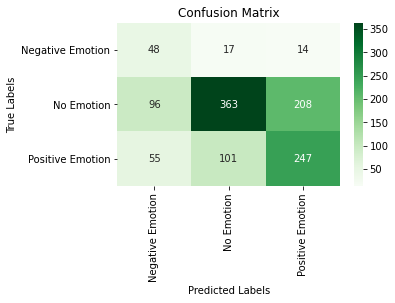

In [317]:
print("**************** COMPLEMENT NAIVE BAYES CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,pred_y_nb),3))
print('F1 score for testing set: ',round(f1_score(y_test,pred_y_nb,average='weighted'),3))
print('Recall score for testing set: ',round(recall_score(y_test,pred_y_nb,average='weighted'),3))
print('Precision score for testing set: ',round(precision_score(y_test,pred_y_nb,average='weighted'),3))
cm_nb = confusion_matrix(y_test, pred_y_nb)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_nb, annot=True, cmap='Greens', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion']) ; 
ax.yaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show();

### Model 4 - Random Forest Classifier Model
* Random forest is an ensemble machine learning algorithm.
* A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

In [318]:
rf = RandomForestClassifier()
rf.fit(X_train_over, y_train_over)
ytest = np.array(y_test)
pred_y_rf = rf.predict(X_test)
rf_df = pd.DataFrame(pred_y_rf,columns=["Pred_RandomForest"])

In [319]:
print(classification_report(y_test,pred_y_rf))

                  precision    recall  f1-score   support

Negative emotion       0.55      0.20      0.30        79
 Neutral emotion       0.67      0.86      0.75       667
Positive emotion       0.62      0.40      0.48       403

        accuracy                           0.65      1149
       macro avg       0.61      0.49      0.51      1149
    weighted avg       0.64      0.65      0.63      1149



**************** DEFAULT RANDOM FOREST CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.654
F1 score for testing set:  0.627
Recall score for testing set:  0.654
Precision score for testing set:  0.643


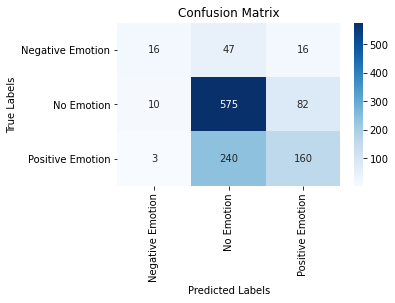

In [320]:
print("**************** DEFAULT RANDOM FOREST CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,pred_y_rf),3))
print('F1 score for testing set: ',round(f1_score(y_test,pred_y_rf,average='weighted'),3))
print('Recall score for testing set: ',round(recall_score(y_test,pred_y_rf,average='weighted'),3))
print('Precision score for testing set: ',round(precision_score(y_test,pred_y_rf,average='weighted'),3))
cm_rf = confusion_matrix(y_test, pred_y_rf)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion']) ; 
ax.yaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show();

### Model Performance Comparison

#### Accuracy Performance Metric

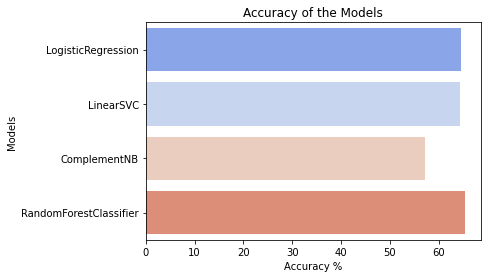

In [321]:
models = [lr,svc,nbc,rf]

result = []
results = pd.DataFrame(columns= ["Models","Accuracy"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)    
    result = pd.DataFrame([[names, accuracy*100]], columns= ["Models","Accuracy"])
    results = results.append(result)
    
    
sns.barplot(x= 'Accuracy', y = 'Models', data=results, palette="coolwarm")
plt.xlabel('Accuracy %')
plt.title('Accuracy of the Models');

In [322]:
results

Models   Accuracy
0      LogisticRegression  64.577894
0               LinearSVC  64.490862
0            ComplementNB  57.267189
0  RandomForestClassifier  65.361184

* Accuracy allows one to measure the total number of prediction a model gets right. It is used when true positives and true negatives are important. 
* The best performing model will have the highest accuracy.
* Of the four models tested, random forest classifier has the highest accuracy.

#### F1 Score Performance Metric

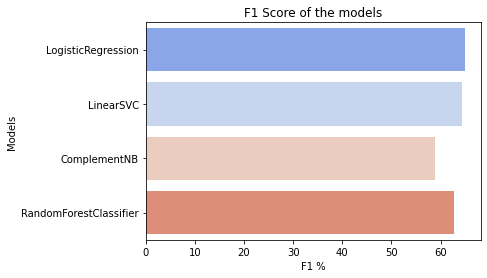

In [323]:
models = [lr,svc,nbc,rf]

result = []
results = pd.DataFrame(columns= ["Models","F1"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred,average='weighted')    
    result = pd.DataFrame([[names, f1*100]], columns= ["Models","F1"])
    results = results.append(result)
    
    
sns.barplot(x= 'F1', y = 'Models', data=results, palette="coolwarm")
plt.xlabel('F1 %')
plt.title('F1 Score of the models');

In [324]:
results

Models         F1
0      LogisticRegression  64.910921
0               LinearSVC  64.455734
0            ComplementNB  58.955545
0  RandomForestClassifier  62.678285

* F1 score measures the harmonic mean between precision and recall
* It is a value between 0 and 1, with 1 being a perfect score and an indication everything was observed correctly.
* Linear SVC had the highest F1 score.

### Hyperparameter Tuning of Random Forest Classifier
* As accuracy is the more relevant metric in this analysis, the best performing model from that analysis will be used for hyperparameter tuning.
* In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

In [325]:
# Commenting this out due to lengthy runtime. Snippet of actual cell being ran attached below. 

# rf_params = {"max_depth": [5,8,10],
#              "max_features":[8,10,12],
#              "n_estimators":[250,500,750],
#              "min_samples_split":[5,10,15]}

In [326]:
# Commenting this out due to lengthy runtime. Snippet of actual cell being ran attached below. 

# rf_model2 = RandomForestClassifier()
# rf_cv_model = GridSearchCV(rf_model2,rf_params,cv=3,n_jobs=-1,verbose=2)
# rf_cv_model.fit(X_train_over,y_train_over)
# print("Best parameters:"+str(rf_cv_model.best_params_))

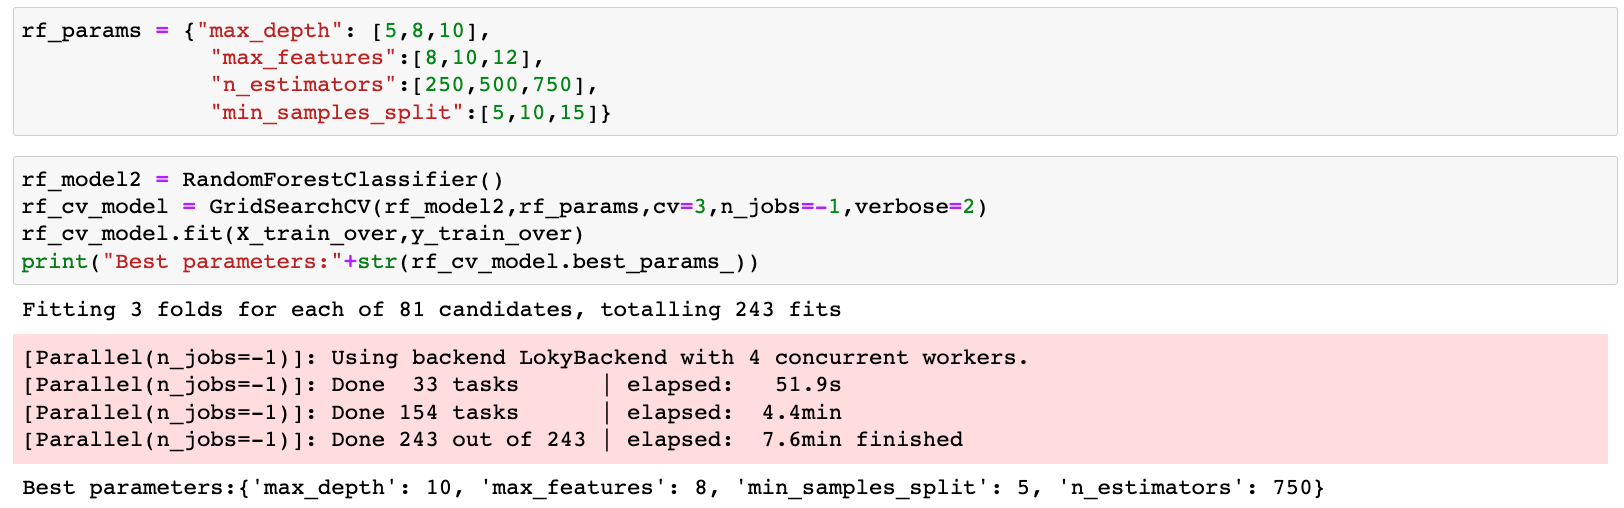

In [327]:
rf_model_final = RandomForestClassifier(max_depth=10,max_features=8,min_samples_split=5,n_estimators=1000)
rf_model_final.fit(X_train_over,y_train_over)
y_pred_final = rf_model_final.predict(X_test)

**************** HYPER-PARAMETER TUNED RANDOM FOREST MODEL RESULTS **************** 
Accuracy score for testing set:  0.65013
F1 score for testing set:  0.63135
Recall score for testing set:  0.65013
Precision score for testing set:  0.63493


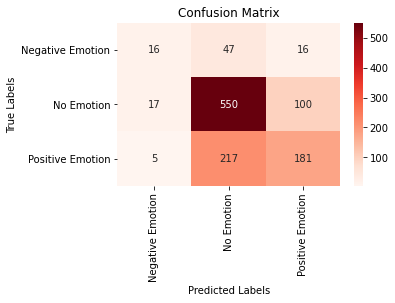

In [328]:
print("**************** HYPER-PARAMETER TUNED RANDOM FOREST MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_final),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_final,average='weighted'),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_final,average='weighted'),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_final,average='weighted'),5))
cm_rf = confusion_matrix(y_test, y_pred_final)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_rf, annot=True, cmap='Reds', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion']) ; 
ax.yaxis.set_ticklabels(['Negative Emotion', 'No Emotion','Positive Emotion'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show();

* In comparison to the original random forest model ran, the hyperparameter tuned one has a slightly lower accuracy.
* The confusion matrix above has lower numbers than the one of the original model. This indicates it will not be able to make as many predictions as the first model.

### Modeling Conclusions 
* In total, five models were ran, four of them being different kinds of models. Then, they were compared in terms of accuracy and F1 score. 
* The original Random Forest Classifier yielded the highest accuracy rate, making it the best fit model. 
* Accuracy is the best metric to use in assessing the best fit model for this case as it is the percentage of the data that is correctly classified. 

## Real Tweet Classes versus Models' Predictions
The section below runs all of the models against the original tagged emotions in the dataset.

In [330]:
final_merged_df = pd.concat([df2[['clean_tweet','emotion']],naive_df,svc_df,log_df,rf_df], axis=1).dropna()
final_merged_df.head(20)

clean_tweet  \
3                                                         i hope this year s festival isn t as crashy as this year s iphone app    
8                                                 beautifully smart and simple idea rt wrote about our hollergram ipad app for     
9                                            counting down the days to  plus strong canadian dollar means stock up on apple gear   
10                                  excited to meet the at  so i can show them my sprint galaxy s still running android 2 1 fail   
14                                                                                                         great  ipad app from    
15                                                                                    haha awesomely rad ipad app by hollergram    
16                                                                             holler gram for ipad on the itunes app store via    
20                          need to buy an ipad2 while i m in austin at  not sure if i ll need to q up at an austin apple store    
22                                                                    okay this is really it yay new for android app 11 kthxbai    
26                                                                            rt haha awesomely rad ipad app by hollergram  via    
27                                                              someone started an austin group in google groups pre  great idea   
29                                                  they were right the 3 app on android is sweeeeet nice job by the team there    
30                                                   very smart from hollergram ipad app for  may leave my vuvuzela at home now    
33                                                                                       anyone at  want to sell their old ipad    
35                                     at  oooh rt google to launch major new social network called circles possibly today link    
36        the best rt ha first in line for ipad2 at  quot pop up quot apple store was an event planner eventprofs pcma engage365   
37                                      spin play a new concept in music discovery for your ipad from amp spin com link itunes     
39                                                                  vatornews google and apple force print media to evolve link    
40   great weather to greet you for  still need a sweater at night apple putting up quot flash store quot downtown to sell ipad2   
42                     hey  how long do you think it takes us to make an iphone case answer using zazzle and we ll make you one    

             emotion Pred_ComplementNB          Pred_SVC  \
3   Negative emotion  Positive emotion  Positive emotion   
8   Positive emotion  Positive emotion  Positive emotion   
9   Positive emotion  Positive emotion  Positive emotion   
10  Positive emotion   Neutral emotion   Neutral emotion   
14  Positive emotion   Neutral emotion   Neutral emotion   
15  Positive emotion   Neutral emotion   Neutral emotion   
16   Neutral emotion  Positive emotion   Neutral emotion   
20  Positive emotion  Positive emotion  Positive emotion   
22  Positive emotion   Neutral emotion   Neutral emotion   
26  Positive emotion   Neutral emotion   Neutral emotion   
27  Positive emotion  Positive emotion  Positive emotion   
29  Positive emotion  Positive emotion  Positive emotion   
30  Positive emotion  Positive emotion  Positive emotion   
33   Neutral emotion  Negative emotion  Negative emotion   
35   Neutral emotion  Negative emotion  Negative emotion   
36  Positive emotion   Neutral emotion   Neutral emotion   
37   Neutral emotion  Positive emotion  Positive emotion   
39   Neutral emotion  Positive emotion   Neutral emotion   
40  Positive emotion   Neutral emotion  Positive emotion   
42   Neutral emotion   Neutral emotion   Neutral emotion   

   Pred_LogisticRegression Pred_RandomForest  
3         Positive emotion  Positive

* For some of the tweets, the tested models seem to accurately reflect the emotion that was initially tagged to the tweet. 
* For other tweets, the predicted models have predicted an emotion different from the initially tagged one.

### Most Common Words in the Different Emotions